### Notebook Summary

Takes population density rasters, averages across states level (median across adm1), then calculates correlation between (log of) state median pop density and inferred mean delay from symptom-onset-to-diagnosis.

In [1]:
import pandas as pd
import numpy as np
import os
import io
import hashlib
import requests
import json
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
import pickle
# import stan
import datetime
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas.tools import sjoin
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy import stats


### Population density

- Population density raster taken from:
https://data.humdata.org/dataset/worldpop-population-density-for-brazil



In [3]:
country_adm_shapefile = {}
country_adm_shapefile['mexico'] = '/Users/felix/Documents/DPhil/global_health/geo_files/mex_admbnda_govmex_20210618_SHP/mex_admbnda_adm2_govmex_20210618.shp'
country_adm_shapefile['colombia'] = '/Users/felix/Documents/DPhil/global_health/geo_files/col-administrative-divisions-shapefiles/col_admbnda_adm2_mgn_20200416.shp'
country_adm_shapefile['brazil'] = '/Users/felix/Documents/DPhil/global_health/geo_files/bra_adm_ibge_2020_shp/bra_admbnda_adm2_ibge_2020.shp'
country_adm_shapefile['argentina'] = '/Users/felix/Documents/DPhil/global_health/geo_files/arg_adm_unhcr2017_shp/arg_admbnda_adm2_unhcr2017.shp'


In [4]:
pd_raster_files = {}
pd_raster_files['mexico'] = "/Users/felix/Documents/DPhil/global_health/geo_files/pop_density/mex_pd_2020_1km_ASCII_XYZ.csv"
pd_raster_files['colombia'] = "/Users/felix/Documents/DPhil/global_health/geo_files/pop_density/col_pd_2020_1km_ASCII_XYZ.csv"
pd_raster_files['brazil'] = "/Users/felix/Documents/DPhil/global_health/geo_files/pop_density/bra_pd_2020_1km_ASCII_XYZ.csv"
pd_raster_files['argentina'] = "/Users/felix/Documents/DPhil/global_health/geo_files/pop_density/arg_pd_2020_1km_ASCII_XYZ.csv"


In [5]:
means_file = "/Users/felix/Documents/DPhil/global_health/delay_distributions/inferred_means/all_means (1).csv"
means = pd.read_csv(means_file).drop(columns="Unnamed: 0")
means.replace('onset-from-death-hospitalisation','hospitalisation-to-death',inplace=True)
means['Mean'] = means['Mean'].round(decimals=2)
new_col_order = ['Country','Delay', 'Epoch', 'State', 'Mean', 'Count']


In [6]:
pd_adm_aggregated_dict = {}
for country in country_adm_shapefile.keys():
    df = pd.read_csv(pd_raster_files[country], sep=',')
    gdf2d = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))
    country_shapefile = gpd.read_file(country_adm_shapefile[country])
    joined = gpd.sjoin(gdf2d,country_shapefile)
    adm1_colname = [u for u in country_shapefile.columns if 'ADM1' in u][0]
    pd_adm_aggregated = joined.groupby(adm1_colname).median()
    pd_adm_aggregated_dict[country] = pd_adm_aggregated
    pd_adm_aggregated_dict[country]['log_Z'] = np.log(pd_adm_aggregated_dict[country]['Z'])

/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_73493/904991678.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(gdf2d,country_shapefile)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_73493/904991678.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(gdf2d,country_shapefile)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_73493/904991678.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined

<AxesSubplot:>

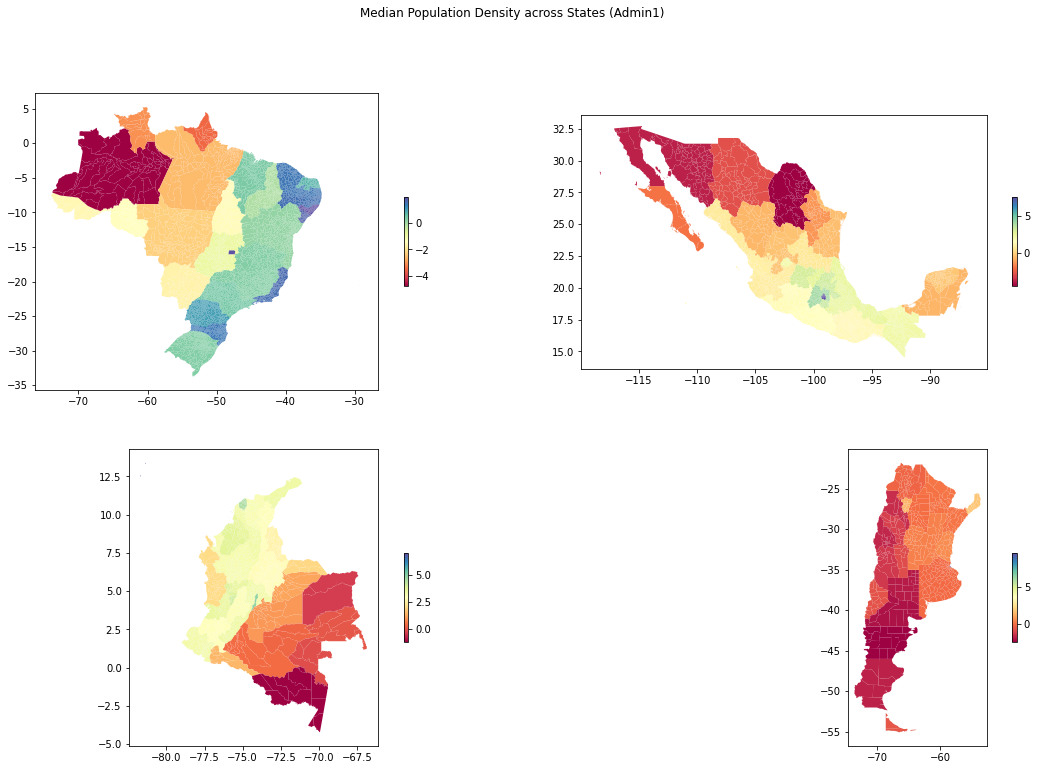

In [21]:
fig,ax = plt.subplots(2,2,figsize=(20,12))
fig.suptitle('Median Population Density across States (Admin1)',fontsize=24)

country = 'brazil' 
country_shapefile = gpd.read_file(country_adm_shapefile[country])
country_shapefile_with_pd = country_shapefile.merge(pd_adm_aggregated_dict[country],left_on='ADM1_PT',right_index=True)
country_shapefile_with_pd.plot(column='log_Z',cmap='Spectral',legend=True,legend_kwds={'shrink': 0.3},figsize=(20,12),ax=ax[0,0])

country = 'mexico' 
country_shapefile = gpd.read_file(country_adm_shapefile[country])
country_shapefile_with_pd = country_shapefile.merge(pd_adm_aggregated_dict[country],left_on='ADM1_ES',right_index=True)
country_shapefile_with_pd.plot(column='log_Z',cmap='Spectral',legend=True,legend_kwds={'shrink': 0.3},figsize=(20,12),ax=ax[0,1])

country = 'colombia' 
country_shapefile = gpd.read_file(country_adm_shapefile[country])
country_shapefile_with_pd = country_shapefile.merge(pd_adm_aggregated_dict[country],left_on='ADM1_ES',right_index=True)
country_shapefile_with_pd.plot(column='log_Z',cmap='Spectral',legend=True,legend_kwds={'shrink': 0.3},figsize=(20,12),ax=ax[1,0])

country = 'argentina' 
country_shapefile = gpd.read_file(country_adm_shapefile[country])
country_shapefile_with_pd = country_shapefile.merge(pd_adm_aggregated_dict[country],left_on='ADM1_ES',right_index=True)
country_shapefile_with_pd.plot(column='log_Z',cmap='Spectral',legend=True,legend_kwds={'shrink': 0.3},figsize=(20,12),ax=ax[1,1])

### Load adm1 aggregated dict of countries

In [23]:
pd_adm_aggregated_dict = {}
for country in country_adm_shapefile.keys():
    country_pd_adm_aggregated = pd.read_csv(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/{country}_pop_density_adm1.csv')
    country_pd_adm_aggregated = country_pd_adm_aggregated.set_index([u for u in country_pd_adm_aggregated.columns if 'ADM1' in u][0])
    pd_adm_aggregated_dict[country] = country_pd_adm_aggregated

In [24]:
pd_adm_aggregated_dict[country].head()

,X,Y,Z,index_right,log_Z
ADM1_ES,,,,,
Buenos Aires,-60.597083,-36.629583,0.936587,245.0,-0.065513
Catamarca,-67.038750,-27.362916,0.232689,325.0,-1.458053
Chaco,-60.822083,-26.504583,1.117980,170.0,0.111523
Chubut,-68.597083,-43.704583,0.093013,229.0,-2.375016
Ciudad de Buenos Aires,-58.447083,-34.612916,13539.704102,335.0,9.513382


### Mean all epochs

/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

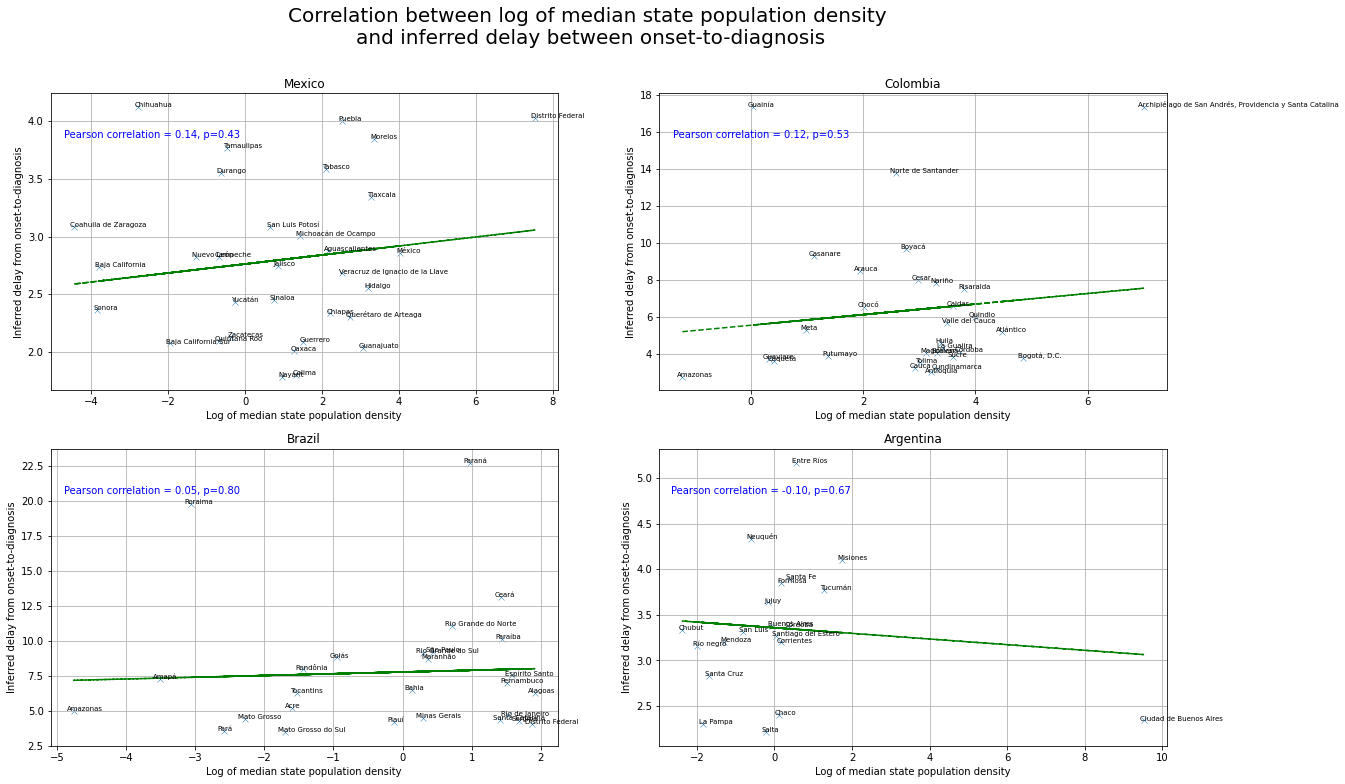

In [65]:
save = True

remove_x_quantiles = False
x_upper_threshold = 0.95
x_lower_threshold = 0.05

remove_y_quantiles = False
y_upper_threshold = 0.95
y_lower_threshold = 0.05

fig,axes = plt.subplots(2,2,figsize=(20,12))

for k,country in enumerate(country_adm_shapefile.keys()):
    mean_all_epochs = means.loc[(means['Country']==country) & (means['Delay']=='onset-to-diagnosis')].groupby('State').mean()
    regression_df = pd_adm_aggregated_dict[country].merge(mean_all_epochs,left_index=True,right_index=True)[['Mean','log_Z']]
    # if country == 'argentina':
    #     regression_df = regression_df.drop('Ciudad de Buenos Aires')
    ax=axes.flat[k]
    x = regression_df['log_Z']
    y = regression_df['Mean']
    if remove_x_quantiles:
        regression_df = regression_df.loc[(x<x.quantile(x_upper_threshold)) & (x>x.quantile(x_lower_threshold))]
    if remove_y_quantiles:
        regression_df = regression_df.loc[(y<y.quantile(y_upper_threshold)) & (y>y.quantile(y_lower_threshold))]   
        
    x = regression_df['log_Z']
    y = regression_df['Mean']
    
    sns.scatterplot(x,y,ax=ax,marker='x')
    ax.grid(visible=True)
    ax.set_xlabel('Log of median state population density')
    ax.set_ylabel('Inferred delay from onset-to-diagnosis')
    ax.set_title(country.capitalize())
    spearman_correlation = spearmanr(x,y)
    pearson_correlation = pearsonr(x,y)
    linear_regress_res = stats.linregress(x,y)
    ax.plot(x, linear_regress_res.intercept + linear_regress_res.slope*x, color='g', linestyle='dashed', label='fitted line')

    for name,row in regression_df.iterrows():
        ax.text(row['log_Z']-0.1,row['Mean'],name,fontsize=7)
        
    # ax.text(0.9, 0.9,f"Spearman correlation = {spearman_correlation[0]:.2f}, p={spearman_correlation[1]:.2f}",
    #        horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='r')
    ax.text(0.2, 0.86,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='b')

    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue**2:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    

     
    # ax.text(0.5,0.4,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}")
    
    if save:
        pd_adm_aggregated_dict[country].to_csv(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/{country}_pop_density_adm1.csv')
        regression_df.to_csv(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/{country}_mean_delay_onset_to_diagnosis_pop_density_adm1.csv')
if remove_x_quantiles:
    fig.suptitle('Correlation between log of median state population density \nand inferred delay between onset-to-diagnosis, outliers removed',fontsize=20)
else:
    fig.suptitle('Correlation between log of median state population density \nand inferred delay between onset-to-diagnosis',fontsize=20)
# fig.tight_layout()

if save:
    if remove_x_quantiles:
        plt.savefig('/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_outliers_removed.png')
        plt.savefig('/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_outliers_removed.svg')
    else:
        plt.savefig('/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis.png')
        plt.savefig('/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis.svg')

### Mean epoch 1

/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

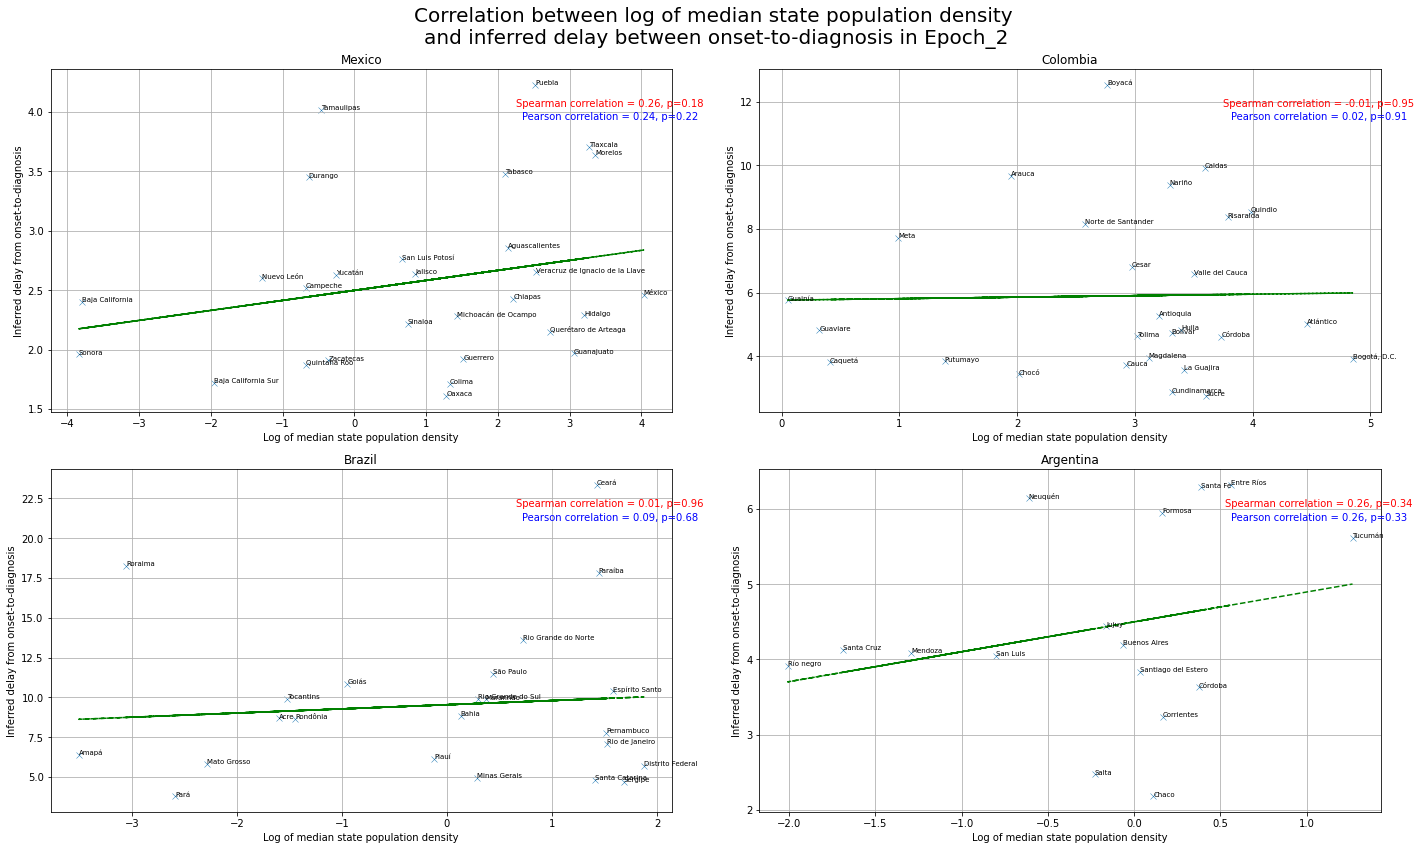

In [49]:
save = False

remove_x_quantiles = True
x_upper_threshold = 0.95
x_lower_threshold = 0.05

remove_y_quantiles = True
y_upper_threshold = 0.95
y_lower_threshold = 0.05

epoch = 'Epoch_1'
fig,axes = plt.subplots(2,2,figsize=(20,12))
for k,country in enumerate(country_adm_shapefile.keys()):
    mean_epochs = means.loc[(means['Country']==country) & (means['Delay']=='onset-to-diagnosis')& (means['Epoch']==epoch)].groupby('State').mean()
    regression_df = pd_adm_aggregated_dict[country].merge(mean_epochs,left_index=True,right_index=True)[['Mean','log_Z']]
    ax=axes.flat[k]
    x = regression_df['log_Z']
    y = regression_df['Mean']
    
    if remove_x_quantiles:
        regression_df = regression_df.loc[(x<x.quantile(x_upper_threshold)) & (x>x.quantile(x_lower_threshold))]
    if remove_y_quantiles:
        regression_df = regression_df.loc[(y<y.quantile(y_upper_threshold)) & (y>y.quantile(y_lower_threshold))]   
        
    x = regression_df['log_Z']
    y = regression_df['Mean']
        
    sns.scatterplot(x,y,ax=ax,marker='x')
    ax.grid(visible=True)
    ax.set_xlabel('Log of median state population density')
    ax.set_ylabel('Inferred delay from onset-to-diagnosis')
    ax.set_title(country.capitalize())
    spearman_correlation = spearmanr(x,y)
    pearson_correlation = pearsonr(x,y)
    linear_regress_res = stats.linregress(x,y)
    ax.plot(x, linear_regress_res.intercept + linear_regress_res.slope*x, color='g', linestyle='dashed', label='fitted line')

    for name,row in regression_df.iterrows():
        ax.text(row['log_Z'],row['Mean'],name,fontsize=7)
        
    ax.text(0.9, 0.9,f"Spearman correlation = {spearman_correlation[0]:.2f}, p={spearman_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='r')
    ax.text(0.9, 0.86,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='b')

    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue**2:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    

     
    # ax.text(0.5,0.4,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}")
fig.suptitle(f'Correlation between log of median state population density \nand inferred delay between onset-to-diagnosis in {epoch}',fontsize=20)
fig.tight_layout()

if save:
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.png')
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.svg')

### Mean Epoch 2

/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

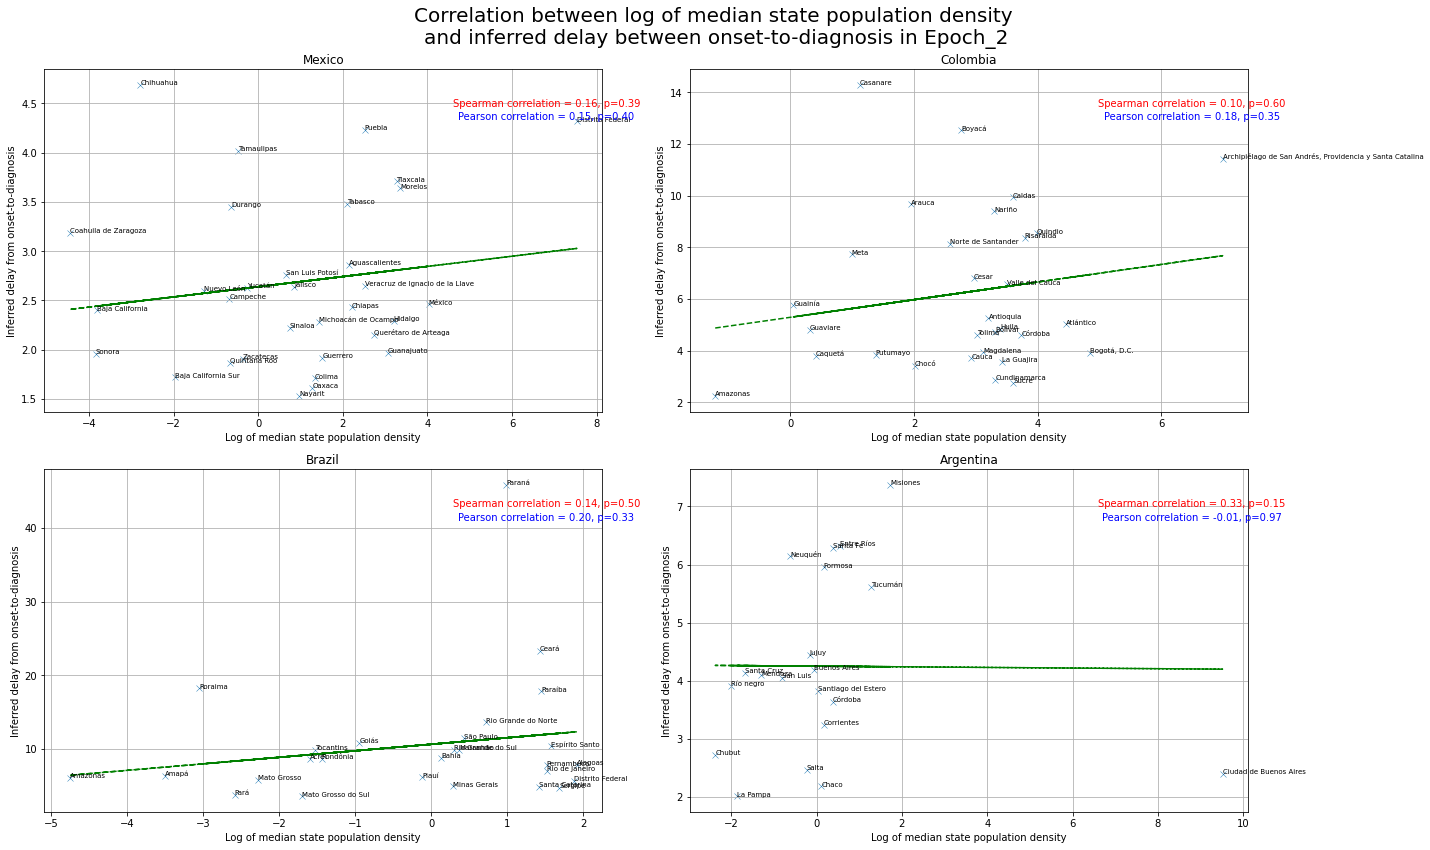

In [103]:
save = False

remove_x_quantiles = True
x_upper_threshold = 0.95
x_lower_threshold = 0.05

remove_y_quantiles = True
y_upper_threshold = 0.95
y_lower_threshold = 0.05

epoch = 'Epoch_2'
fig,axes = plt.subplots(2,2,figsize=(20,12))
for k,country in enumerate(country_adm_shapefile.keys()):
    mean_epochs = means.loc[(means['Country']==country) & (means['Delay']=='onset-to-diagnosis')& (means['Epoch']==epoch)].groupby('State').mean()
    regression_df = pd_adm_aggregated_dict[country].merge(mean_epochs,left_index=True,right_index=True)[['Mean','log_Z']]
    ax=axes.flat[k]
    x = regression_df['log_Z']
    y = regression_df['Mean']
    
    if remove_x_quantiles:
        regression_df = regression_df.loc[(x<x.quantile(x_upper_threshold)) & (x>x.quantile(x_lower_threshold))]
    if remove_y_quantiles:
        regression_df = regression_df.loc[(y<y.quantile(y_upper_threshold)) & (y>y.quantile(y_lower_threshold))]   
        
    x = regression_df['log_Z']
    y = regression_df['Mean']
        
    sns.scatterplot(x,y,ax=ax,marker='x')
    ax.grid(visible=True)
    ax.set_xlabel('Log of median state population density')
    ax.set_ylabel('Inferred delay from onset-to-diagnosis')
    ax.set_title(country.capitalize())
    spearman_correlation = spearmanr(x,y)
    pearson_correlation = pearsonr(x,y)
    linear_regress_res = stats.linregress(x,y)
    ax.plot(x, linear_regress_res.intercept + linear_regress_res.slope*x, color='g', linestyle='dashed', label='fitted line')

    for name,row in regression_df.iterrows():
        ax.text(row['log_Z'],row['Mean'],name,fontsize=7)
        
    ax.text(0.9, 0.9,f"Spearman correlation = {spearman_correlation[0]:.2f}, p={spearman_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='r')
    ax.text(0.9, 0.86,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='b')

    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue**2:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    

     
    # ax.text(0.5,0.4,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}")
fig.suptitle(f'Correlation between log of median state population density \nand inferred delay between onset-to-diagnosis in {epoch}',fontsize=20)
fig.tight_layout()

if save:
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.png')
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.svg')

### Mean Epoch 3

/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

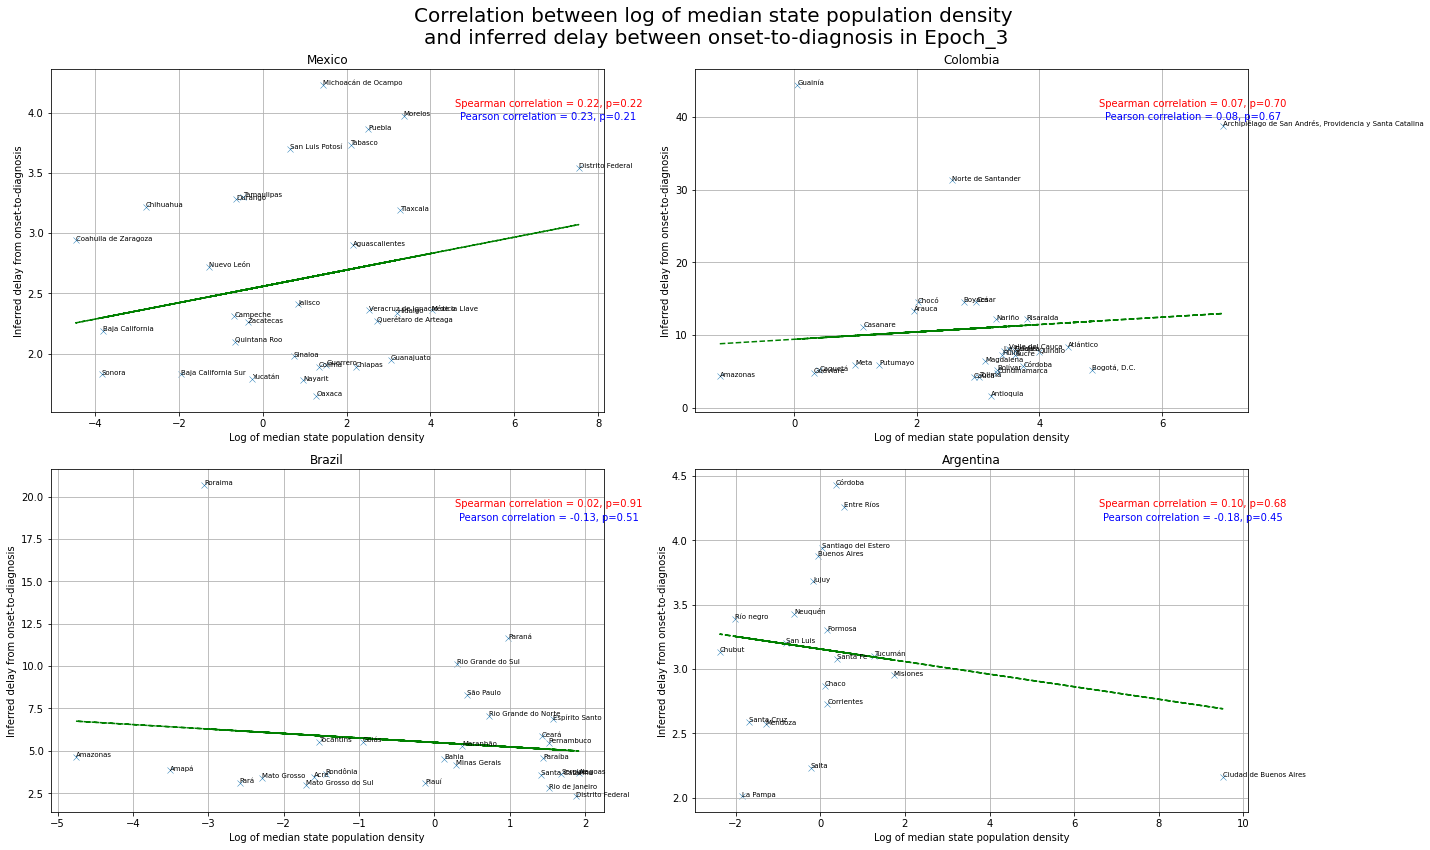

In [104]:
save = False

remove_x_quantiles = True
x_upper_threshold = 0.95
x_lower_threshold = 0.05

remove_y_quantiles = True
y_upper_threshold = 0.95
y_lower_threshold = 0.05

epoch = 'Epoch_3'
fig,axes = plt.subplots(2,2,figsize=(20,12))
for k,country in enumerate(country_adm_shapefile.keys()):
    mean_epochs = means.loc[(means['Country']==country) & (means['Delay']=='onset-to-diagnosis')& (means['Epoch']==epoch)].groupby('State').mean()
    regression_df = pd_adm_aggregated_dict[country].merge(mean_epochs,left_index=True,right_index=True)[['Mean','log_Z']]
    ax=axes.flat[k]
    x = regression_df['log_Z']
    y = regression_df['Mean']
    
    if remove_x_quantiles:
        regression_df = regression_df.loc[(x<x.quantile(x_upper_threshold)) & (x>x.quantile(x_lower_threshold))]
    if remove_y_quantiles:
        regression_df = regression_df.loc[(y<y.quantile(y_upper_threshold)) & (y>y.quantile(y_lower_threshold))]   
        
    x = regression_df['log_Z']
    y = regression_df['Mean']
        
    sns.scatterplot(x,y,ax=ax,marker='x')
    ax.grid(visible=True)
    ax.set_xlabel('Log of median state population density')
    ax.set_ylabel('Inferred delay from onset-to-diagnosis')
    ax.set_title(country.capitalize())
    spearman_correlation = spearmanr(x,y)
    pearson_correlation = pearsonr(x,y)
    linear_regress_res = stats.linregress(x,y)
    ax.plot(x, linear_regress_res.intercept + linear_regress_res.slope*x, color='g', linestyle='dashed', label='fitted line')

    for name,row in regression_df.iterrows():
        ax.text(row['log_Z'],row['Mean'],name,fontsize=7)
        
    ax.text(0.9, 0.9,f"Spearman correlation = {spearman_correlation[0]:.2f}, p={spearman_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='r')
    ax.text(0.9, 0.86,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}",
           horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='b')

    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue**2:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    # ax.text(0.9,0.82,f"R-squared: {linear_regress_res.rvalue:.4f}",horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='g')
    

     
    # ax.text(0.5,0.4,f"Pearson correlation = {pearson_correlation[0]:.2f}, p={pearson_correlation[1]:.2f}")
fig.suptitle(f'Correlation between log of median state population density \nand inferred delay between onset-to-diagnosis in {epoch}',fontsize=20)
fig.tight_layout()

if save:
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.png')
    plt.savefig(f'/Users/felix/Documents/DPhil/global_health/delay_distributions/correlation_pop_density_onset_diagnosis_{epoch}.svg')